# Prediction of Readmission of Diabetic Patients from 1999-2008

## Overview

This project will create classification models to predict hospital readmissions regarding patients with diabetes through data provided by Virginia Commonwealth University (downloaded from kaggle) from 1999-2008 with 130 U.S. hospitals. Predicting high risk patients will provide valuable information to the careproviders to better prepare future care needs of diabetic patients.

## Business Problem

Determining treatment effectiveness within diabetic pateints is an ardous process. Therefore, predicting readmission possibility of patients would allow care-providers to determine treatment qaulity, effectiveness, and prepare further treatment plans if necessary. Also, classifying high risk patients would determine ineffective or errorneous treatments, reducing treatment risks in the future. This prediction model will provide insight to treatment effecitiveness, cost reduction method, and reduced medical risks to careproviders. Hospitals and insurance angency can utilize this model to increase logistical and financial support for highly effective treatments and high risk patients.

## Data

The data provided by Virginia Commonwealth University collected from 130 U.S. hospitals over the years of 1999-2008 on diabetic pateints. The data is separated by unique patient ID and provides features such as number of medications, hospital stays, and sex. The readmission status was defined as "No", no readmission in that year, "<30", readmitted within 30 days of last visit, and ">30", readmitted after 30 days period.

A supporting documetion, description.pdf, Impatct of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Databse Patient Records was also provided as reference.

## Methods

1. Clean data set by creating dummy variables for categorical data 
    - Diagnosis categorized per ICD9 code group defined by related study refere to decription.pdf page 5 table 2.
    - Dropped irrelevant or largely missing data columns such as pateint ID and weight.
2. Perform EDA on cleaned data to gain understanding of statistical significance for feature engineering. Also create data visualizatoin of statistically signifiant features.
3. Create baseline models for iterative improvements using recall as the scoring metric.
4. Select best perfomring model and crate final prediction for model performance analysis.
5. Compare feature weights and ranks among the best performing model to determine significant indicators of readmission prediction. 

## Conclusion

Care providers can utilize the random forest model to predict future readmission possibility of a patient. This will allow the hosptials to idenify high risk patients and predict readmission patient count to plan treatment and logistic necessities accordingly. All features indentified in EDA process were ranked high in feature importance of all models. Number of inpatients visits, diagnoses, and medication were among the highest in all models. It is recommeded that care providers also utilize these metrics in determining patient care. 


## Next Steps

- Create more interpretable models to aid treatment process for care providers. 
- Obtain more recent data and check for relevant performance. 

## Library Import

In [99]:
import pickle
import pandas as pd
import json
import os
import scipy.stats as stat
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from source.CustomLibrary import clean

## Import Data

In [33]:
df = pd.read_csv('data/diabetic_data.csv')

## Exploratory Data Analysis

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [5]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


### T-test on Select Features

alpha = 0.5 <br>

Selected Features = Number of Medication, Procedure, and Lab Procedures <Br>

Null Hypothesis: Selected Features are not significant factors determining readmission. <br>
Alternative Hypothesis: Selected Features are significant factors determining readmission. <br>

## Data Cleaning

In [21]:
clean_df = pd.read_csv("data/diabetic_data_preclean.csv", index_col=0)

In [7]:
features = ["num_medications", "num_procedures", "num_lab_procedures", "number_outpatient", "number_inpatient"]
alpha = 0.05

for feature in features:
    #slice data
    readmit_0 = clean_df[clean_df.readmitted == 0][feature]
    readmit_1 = clean_df[clean_df.readmitted == 1][feature]
    readmit_2 = clean_df[clean_df.readmitted == 2][feature]
    
    #series of t-test
    num_med_0_1 = stat.ttest_ind(readmit_0, readmit_1, equal_var = False)[1]
    num_med_1_2 = stat.ttest_ind(readmit_1, readmit_2, equal_var = False)[1]
    num_med_0_2 = stat.ttest_ind(readmit_0, readmit_2, equal_var = False)[1]
    
    if num_med_0_1 <= alpha:
        print(f"{feature} T-test for readmission 0 vs 1 P-value: ", num_med_0_1)
        print("Reject Null Hypothesis", "\n")
    else:
        print(f"{feature} T-test for readmission 0 vs 1 P-value: ", num_med_0_1)
        print("FAILURE to Reject Null Hypothesis", "\n")
    if num_med_1_2 <= alpha:
        print(f"{feature} T-test for readmission 1 vs 2 P-value: ", num_med_1_2)
        print("Reject Null Hypothesis", "\n")
    else:
        print(f"{feature} T-test for readmission 1 vs 2 P-value: ", num_med_1_2)
        print("FAILURE to Reject Null Hypothesis", "\n")
    if num_med_0_2 <= alpha:
        print(f"{feature} T-test for readmission 0 vs 2 P-value: ", num_med_0_2)
        print("Reject Null Hypothesis", "\n")
    else:
        print(f"{feature} T-test for readmission 0 vs 2 P-value: ", num_med_0_2)
        print("FAILURE to Reject Null Hypothesis", "\n")

num_medications T-test for readmission 0 vs 1 P-value:  2.149293623995029e-48
Reject Null Hypothesis 

num_medications T-test for readmission 1 vs 2 P-value:  5.853119998295598e-13
Reject Null Hypothesis 

num_medications T-test for readmission 0 vs 2 P-value:  1.1152690198545309e-29
Reject Null Hypothesis 

num_procedures T-test for readmission 0 vs 1 P-value:  3.495894289451428e-14
Reject Null Hypothesis 

num_procedures T-test for readmission 1 vs 2 P-value:  0.07753339914164716
FAILURE to Reject Null Hypothesis 

num_procedures T-test for readmission 0 vs 2 P-value:  7.285489746058182e-44
Reject Null Hypothesis 

num_lab_procedures T-test for readmission 0 vs 1 P-value:  2.859491382144581e-20
Reject Null Hypothesis 

num_lab_procedures T-test for readmission 1 vs 2 P-value:  0.06186164189328136
FAILURE to Reject Null Hypothesis 

num_lab_procedures T-test for readmission 0 vs 2 P-value:  1.7302681119088142e-27
Reject Null Hypothesis 

number_outpatient T-test for readmission 0 vs 1

#### T-test Results

- Null hypothesis can be rejected for number of medications, statistical significance were found between number of medication in determining readmission status

- Failed to reject null hypothesis on statistical significance of number of procedures determining readmission within or after 30 days. 

- Failed to reject null hypothesis on statistical significance of number of lab procedures determining readmission within or after 30 days. 

- Number of inpatient T-test displaying p-values of 0 demonstrated very large frequency imbalance between the three groups. 

### Violin Plot of significant features

Number of medication, number of inpatient visits, and number of outpatient visits were all significant factors in determining readmission possibility for all outcomes. 

#### Number of Medications

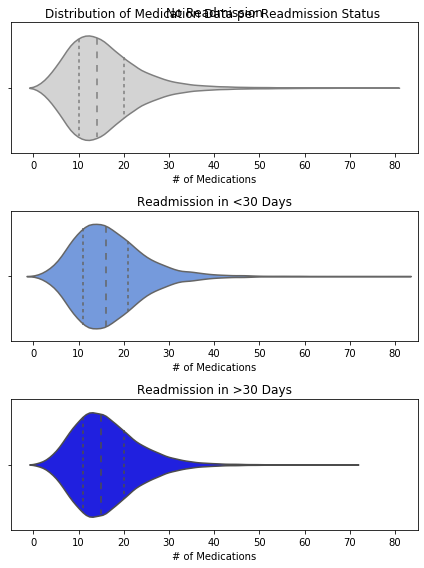

In [8]:
#data slice
x0 = clean_df[clean_df.readmitted == 0]["num_medications"]
x1 = clean_df[clean_df.readmitted == 1]["num_medications"]
x2 = clean_df[clean_df.readmitted == 2]["num_medications"]

#set subplots
fig, ax = plt.subplots(3,1, figsize=(6,8))
#subplot 1
sns.violinplot(x0, color="lightgrey", ax=ax[0], inner="quartile")
ax[0].set_title("No Readmission")
ax[0].set_xlim(-5,85)
ax[0].set_xlabel("# of Medications")

#subplot 2
sns.violinplot(x1, color="cornflowerblue", ax=ax[1], inner="quartile")
ax[1].set_title("Readmission in <30 Days")
ax[1].set_xlim(-5,85)
ax[1].set_xlabel("# of Medications")

#subplot 3
sns.violinplot(x2, color="blue", ax=ax[2], inner="quartile")
ax[2].set_title("Readmission in >30 Days")
ax[2].set_xlim(-5,85)
ax[2].set_xlabel("# of Medications")

#prettify
plt.suptitle("Distribution of Medication Data per Readmission Status")
plt.tight_layout(); #make it neat

plt.show();

Number of medications have small data spared difference when divided by readmission status. First, the readmission within <30 days had highest spread in number of medication. Second, the mean medication among this group was higher than mean of other readmission status. This can be interpreted as high risk (more likely to return) patients are assigned more medicaiton to support them. 

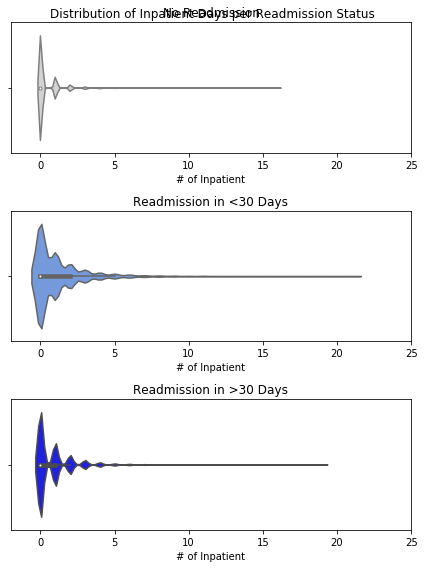

In [9]:
# data slice
x0 = clean_df[clean_df.readmitted == 0]["number_inpatient"]
x1 = clean_df[clean_df.readmitted == 1]["number_inpatient"]
x2 = clean_df[clean_df.readmitted == 2]["number_inpatient"]

# plot
fig, ax = plt.subplots(3,1, figsize=(6,8))
# subplot 1
sns.violinplot(x0, color="lightgrey", alpha=0.7, ax=ax[0])
ax[0].set_title("No Readmission")
ax[0].set_xlim(-2, 25)
ax[0].set_xlabel("# of Inpatient")

# subplot 2
sns.violinplot(x1, color="cornflowerblue", alpha=0.7, ax=ax[1])
ax[1].set_title("Readmission in <30 Days")
ax[1].set_xlim(-2, 25)
ax[1].set_xlabel("# of Inpatient")

# subplot 3
sns.violinplot(x2, color="blue", alpha=0.7, ax=ax[2])
ax[2].set_title("Readmission in >30 Days")
ax[2].set_xlim(-2, 25)
ax[2].set_xlabel("# of Inpatient")

# prettify
plt.suptitle("Distribution of Inpatient Days per Readmission Status")
plt.tight_layout(); #make it neat

plt.show();

Number of inpatient days demonstrated significant data spread when separated by readmission status. Readmission within 30 days shows higher frequency and spared of number of inpatient days. Most patients with no readmission had 0 inpatient visits. 

### Stacked Bar Plots

#### Age

Age Summary


readmitted      0     1     2
age                          
[0-10)        132     3    26
[10-20)       427    40   224
[20-30)       911   236   510
[30-40)      2164   424  1187
[40-50)      5380  1027  3278
[50-60)      9671  1668  5917
[60-70)     12083  2502  7897
[70-80)     13522  3069  9475
[80-90)      8896  2078  6223
[90-100)     1675   310   808


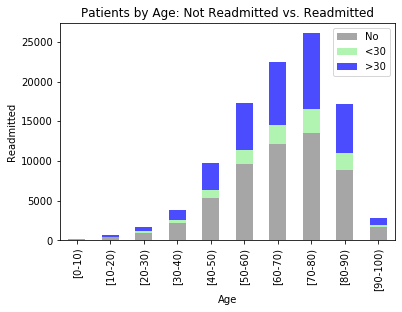

In [10]:
# Age summary
print('Age Summary')

print('\n')
print(clean_df.groupby(['age','readmitted']).age.count().unstack())

# Age class visualization
ageclass = clean_df.groupby(['age','readmitted']).age.count().unstack()
p1 = ageclass.plot(kind = 'bar', stacked = True, 
                   title = 'Patients by Age: Not Readmitted vs. Readmitted', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Age')
p1.set_ylabel('Readmitted')
p1.legend(['No','<30', '>30'])
#plt.savefig('../image/Age_Readmiited.png')
plt.show()

The age category of patients were skewed towards the older (>50) patients.

#### Probability of Readmittance by Age

Probability of Readmittance by Age Summary


readmitted         0         1         2
age                                     
[0-10)      0.819876  0.018634  0.161491
[10-20)     0.617945  0.057887  0.324168
[20-30)     0.549789  0.142426  0.307785
[30-40)     0.573245  0.112318  0.314437
[40-50)     0.555498  0.106040  0.338462
[50-60)     0.560443  0.096662  0.342895
[60-70)     0.537452  0.111289  0.351259
[70-80)     0.518760  0.117740  0.363500
[80-90)     0.517300  0.120835  0.361865
[90-100)    0.599714  0.110992  0.289295


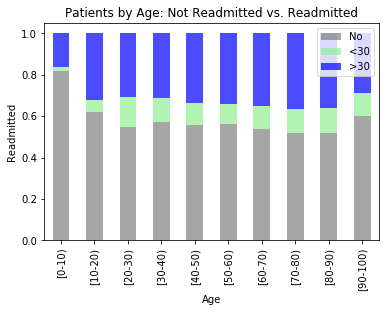

In [11]:
ppa = clean_df.groupby(['age','readmitted']).age.count().unstack()
spa = clean_df.groupby(['age','readmitted']).age.count().unstack()
tpa = clean_df.groupby(['readmitted', 'age']).readmitted.count().unstack().sum()
for x in range(0, 3):
    ppa[x] = spa[x] / tpa

print('Probability of Readmittance by Age Summary')
print('\n')
print(ppa)

# Probability of Readmittance by Age visualization
p1 = ppa.plot(kind = 'bar', stacked = True, 
                   title = 'Patients by Age: Not Readmitted vs. Readmitted', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Age')
p1.set_ylabel('Readmitted')
p1.legend(['No','<30', '>30'])
#plt.savefig('../image/Percentage_Age_Readmitted.png')
plt.show()

From the graph above, we can see that for the most part, as age increases, the probability of readmittance increases. The probability of readmittance after 30 days greater then before 30 days.

#### Length of Hospital Stay

Hospital Stay Summary


readmitted           0     1     2
time_in_hospital                  
1                 8573  1162  4471
2                 9593  1712  5919
3                 9777  1894  6085
4                 7216  1644  5064
5                 5181  1199  3586
6                 3835   949  2755
7                 2984   752  2123
8                 2176   625  1589
9                 1491   412  1099
10                1168   336   838
11                 961   195   699
12                 737   193   518
13                 640   149   421
14                 529   135   378


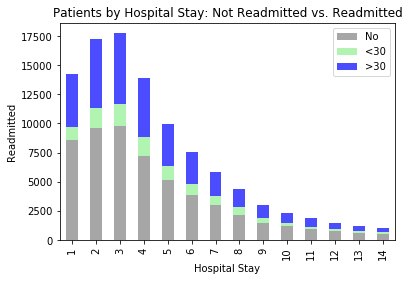

In [12]:
# Hospital Stay class summary
print('Hospital Stay Summary')

print('\n')
print(clean_df.groupby(['time_in_hospital','readmitted']).time_in_hospital.count().unstack())

# Hospital Stay visualization
hospital_stay = clean_df.groupby(['time_in_hospital','readmitted']).time_in_hospital.count().unstack()
p1 = hospital_stay.plot(kind = 'bar', stacked = True, 
                   title = 'Patients by Hospital Stay: Not Readmitted vs. Readmitted', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Hospital Stay')
p1.set_ylabel('Readmitted')
p1.legend(['No','<30', '>30'])
#plt.savefig('../image/Hospital_Stay_Readmitted.png')
plt.show()

There is a skew in the frequency of hospital stay lengths towards stays less than 5 days.

#### Probability of Readmittance by Length of Hospital Stay

Probability of Readmittance by Length of Hospital Stay Summary


readmitted               0         1         2
time_in_hospital                              
1                 0.603477  0.081796  0.314726
2                 0.556955  0.099396  0.343648
3                 0.550631  0.106668  0.342701
4                 0.518242  0.118070  0.363689
5                 0.519868  0.120309  0.359823
6                 0.508688  0.125879  0.365433
7                 0.509302  0.128350  0.362349
8                 0.495672  0.142369  0.361959
9                 0.496669  0.137242  0.366089
10                0.498719  0.143467  0.357814
11                0.518059  0.105121  0.376819
12                0.508978  0.133287  0.357735
13                0.528926  0.123140  0.347934
14                0.507678  0.129559  0.362764


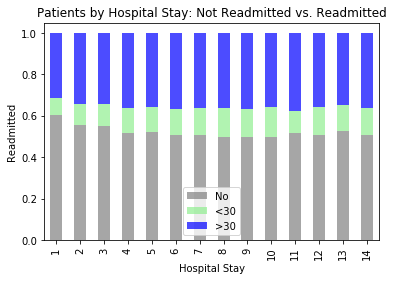

In [13]:
pph = clean_df.groupby(['time_in_hospital','readmitted']).time_in_hospital.count().unstack()
sph = clean_df.groupby(['time_in_hospital','readmitted']).time_in_hospital.count().unstack()
tph = clean_df.groupby(['readmitted', 'time_in_hospital']).readmitted.count().unstack().sum()
for x in range(0, 3):
    pph[x] = sph[x] / tph

print('Probability of Readmittance by Length of Hospital Stay Summary')
print('\n')
print(pph)

# Probability of Readmittance by Length of Hospital Stay Visualization
p1 = pph.plot(kind = 'bar', stacked = True, 
                   title = 'Patients by Hospital Stay: Not Readmitted vs. Readmitted', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Hospital Stay')
p1.set_ylabel('Readmitted')
p1.legend(['No','<30', '>30'])
#plt.savefig('../image/Percentage_Hospital_Stay_Readmitted.png')
plt.show()

As the hospital stay increases, the probability of readmittance increses as well.

#### Number of Diagnoses

Number of Diagnoses Summary


readmitted            0     1      2
number_diagnoses                    
1                   167    13     39
2                   687    62    274
3                  1863   209    763
4                  3473   457   1606
5                  7353  1043   2996
6                  5706  1058   3397
7                  5542  1119   3732
8                  5564  1254   3798
9                 24447  6125  18901
10                    9     3      5
11                    3     3      5
12                    5     1      3
13                    7     3      6
14                    3     1      3
15                    5     2      3
16                   27     4     14


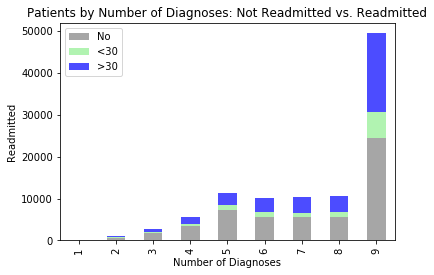

In [14]:
# diagnosis summary
print('Number of Diagnoses Summary')

print('\n')
print(clean_df.groupby(['number_diagnoses','readmitted']).number_diagnoses.count().unstack())

# gender visualization
nodclass = clean_df.groupby(['number_diagnoses','readmitted']).number_diagnoses.count().unstack()
p1 = nodclass.iloc[0:9, :].plot(kind = 'bar', stacked = True, 
                   title = 'Patients by Number of Diagnoses: Not Readmitted vs. Readmitted', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Number of Diagnoses')
p1.set_ylabel('Readmitted')
p1.legend(['No','<30', '>30'])
#plt.savefig('../image/NoD_Readmitted.png')
plt.show()

Due to the lack of data for patients with diagnoses greater than 9, the graph only shows the first 9 bars. Patients with 9 diagnoses are most frequent in the dataset. 

#### Probability of Readmittance by Number of Diagnoses

Probability of Readmittance by Number of Diagnoses Summary


readmitted               0         1         2
number_diagnoses                              
1                 0.762557  0.059361  0.178082
2                 0.671554  0.060606  0.267840
3                 0.657143  0.073721  0.269136
4                 0.627348  0.082551  0.290101
5                 0.645453  0.091555  0.262992
6                 0.561559  0.104124  0.334317
7                 0.533244  0.107669  0.359088
8                 0.524115  0.118124  0.357762
9                 0.494148  0.123805  0.382047
10                0.529412  0.176471  0.294118
11                0.272727  0.272727  0.454545
12                0.555556  0.111111  0.333333
13                0.437500  0.187500  0.375000
14                0.428571  0.142857  0.428571
15                0.500000  0.200000  0.300000
16                0.600000  0.088889  0.311111


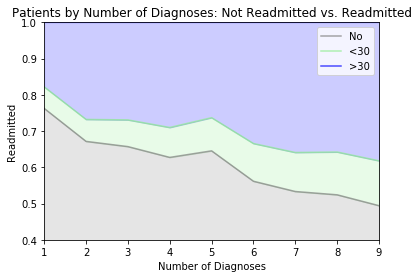

In [15]:
ppnd = clean_df.groupby(['number_diagnoses','readmitted']).number_diagnoses.count().unstack()
spnd = clean_df.groupby(['number_diagnoses','readmitted']).number_diagnoses.count().unstack()
tpnd = clean_df.groupby(['readmitted', 'number_diagnoses']).readmitted.count().unstack().sum()
for x in range(0, 3):
    ppnd[x] = spnd[x] / tpnd

print('Probability of Readmittance by Number of Diagnoses Summary')
print('\n')
print(ppnd)

# Probability of Readmittance by Number of Diagnoses Visualization
# ignoring values greater than 9, due to insignificant amount of data
p1 = ppnd.iloc[0:9, :].plot(kind = 'line', stacked = True, 
                   title = 'Patients by Number of Diagnoses: Not Readmitted vs. Readmitted', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Number of Diagnoses')
p1.set_ylabel('Readmitted')
plt.fill_between(ppnd.iloc[0:9, :].index, ppnd.iloc[0:9, :][0], color = 'gray', alpha = 0.2) # fill in between the lines with color of readmittance
plt.fill_between(ppnd.iloc[0:9, :].index, ppnd.iloc[0:9, :][0] + ppnd.iloc[0:9, :][1], ppnd.iloc[0:9, :][0], color = 'lightgreen', alpha = 0.2)
plt.fill_between(ppnd.iloc[0:9, :].index, 1 - ppnd.iloc[0:9, :][2], 1, color = 'blue', alpha = 0.2)
p1.set_ylim(0.4, 1) # Taking a closer look at change in percentage by only looking above 40%
p1.legend(['No','<30', '>30'])
#plt.savefig('../image/Percentage_NoD_Readmitted.png')
plt.show()

The probability of being readmitted generally increases as the number of diagnoses increases.

## Data Prep for Modeling

In [34]:
clean_tools = clean(df)

In [35]:
df_prep = clean_tools.clean_data() #this can take a bit


In [36]:
df_prep.head()

,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,readmitted,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_11,discharge_disposition_id_12,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_19,discharge_disposition_id_20,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25,age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,metformin_Down,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_Down,glimepiride_Steady,glimepiride_Up,glipizide_Down,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_Steady,glyburide_Up,pioglitazone_Down,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Down,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_Steady,miglitol_Up,tolazamide_Steady,tolazamide_Up,insulin_Down,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_Steady,glyburide-metformin_Up,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_Norm,diag_1_circulatory,diag_1_diabetes,diag_1_digestive,diag_1_genitourinary,diag_1_injury,diag_1_musculoskeletal,diag_1_neoplasms,diag_1_respiratory,diag_2_circulatory,diag_2_diabetes,diag_2_digestive,diag_2_genitourinary,diag_2_injury,diag_2_musculoskeletal,diag_2_neoplasms,diag_2_respiratory,diag_3_circulatory,diag_3_diabetes,diag_3_digestive,diag_3_genitourinary,diag_3_injury,diag_3_musculoskeletal,diag_3_neoplasms,diag_3_respiratory
0,1,1,41,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3,59,0,18,0,0,0,9,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2,11,5,13,2,0,1,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2,44,1,16,0,0,0,7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,51,0,8,0,0,0,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [37]:
df_prep.columns

Index(['gender', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'change',
       ...
       'diag_2_neoplasms', 'diag_2_respiratory', 'diag_3_circulatory',
       'diag_3_diabetes', 'diag_3_digestive', 'diag_3_genitourinary',
       'diag_3_injury', 'diag_3_musculoskeletal', 'diag_3_neoplasms',
       'diag_3_respiratory'],
      dtype='object', length=145)

In [38]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101763 entries, 0 to 101765
Columns: 145 entries, gender to diag_3_respiratory
dtypes: int64(12), uint8(133)
memory usage: 23.0 MB


## Models

### Modeling Strategies and Findings

1. Due to heavy class imbalance in the predictant all readmission status (less than 30 and greater than 30) were upsampled to match the presence of the majority class, no readmission.
<br>
<br>
2. Created baseline models from sklearn Dummy Classifier, Decision Tree Classifier, and Random Forest Classifier.
    - Dummy Classifier was used as a baseline comparison of all models
    - Decision Tree Classifier was used for due to large presence of categorical data.
    - Random Forest Classifier was chosen for its out of box performace and tendency to perform better than decision tree due to ensemble method. 
<br>
<br>
3. Recall scoring method was used to minimize false negatives, since it is better for the careproviders to be overprepared for readmission of patients. The multiclass scoring strategy was `micro` method, which is the global average method. This allowed usage of recall score as the f1 score for other comparisons. 
<br>
<br>
4. Grid search cross validation was used to hypertune individual models. All models saw reduction in overfitting after hypertuning. All models were tuned on max depth, max features, and minimum sample split.
    - Decision Tree was hypertuned twice. First hypertuning was performed on all features. Then, certain features were isolated by their weight from first tuning and the model was hypertuned again with selected features. The second model saw 0.04 incrase in recall score. 
    - Random Forest was hypertuned only once due to it's high recall score, 0.952.
<br> 
<br>
5. The feature importances of all models were compared to each other to see differences in feature rankings. All significant features idenified in EDA were ranked top among all models. All circulatory diagnoses were important features, with emphasis on tertiary and secondary circulatry diagnosis. Insulin and type ii diabetes management drugs were ranked high in all models.
    - Between the 2 Decision Tree models, the select feature model ranked number of inpatient visits, diagnoses, outpatient visits, and emergency visits higher than the other decision tree model.
<br>
<br>
6. Hypertuned Random Forest Classifier was the best model for predicting readmission. 

In [ ]:
# run below to unzip random forest model
# !unzip model\best_grid_rf_clf.zip

### Decision tree model with all features

In [39]:
with open(r"model\best_tree.pickle", "rb") as best_tree:
    grid_tree_all_clf = pickle.load(best_tree)

### Decision tree model with select features and feature names

In [40]:
with open(r"model\best_feature_tree_fit.pickle", "rb") as best_tree_select:
    grid_tree_select_clf = pickle.load(best_tree_select)

In [41]:
# load json file with all features 
with open(r"model\dt_features.json") as feature_json:
    feature_load = json.load(feature_json)

#all features used for gridsearch from json file
features = feature_load["features"]

### Random forest model

In [42]:
with open(r"model\best_grid_rf_clf.pickle", "rb") as rf_clf:
    grid_rf_clf = pickle.load(rf_clf)

In [94]:
X = df_prep.drop(columns="readmitted")
X_eng = X[features]
y = df_prep.readmitted

In [44]:
y_pred_dt = grid_tree_all_clf.predict(X)

In [45]:
y_pred_df_eng = grid_tree_select_clf.predict(X_eng)

In [46]:
y_pred_rf = grid_rf_clf.predict(X)

In [47]:
dt_recall = recall_score(y, y_pred_dt, average="micro")
dt_eng_recall = recall_score(y, y_pred_df_eng, average="micro")
rf_recall = recall_score(y, y_pred_rf, average="micro")

In [48]:
print("Decision Tree Recall: ", dt_recall)
print("Decision Tree with Select Features Recall: ", dt_eng_recall)
print("Random Forest Recall: ", rf_recall)

Decision Tree Recall:  0.6454408773326258
Decision Tree with Select Features Recall:  0.6952133879700874
Random Forest Recall:  0.9411279148610006


All model performance were very close to their average iteration score from modeling process. 

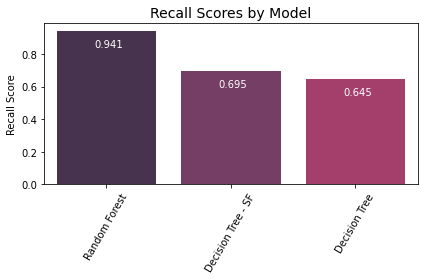

In [93]:
yplot = sorted([dt_recall, dt_eng_recall, rf_recall], reverse=True)
xplot = list(range(0, len(y)))
label = ["Random Forest", "Decision Tree - SF", "Decision Tree"]

sns.set_palette("rocket")
fig, ax = plt.subplots()

sns.barplot(xplot,yplot, ax=ax, alpha=0.9, label=label)
plt.xticks(x, label, rotation=60)
plt.ylabel("Recall Score")

for x_pos, y_pos in zip(xplot,yplot):
    ax.text(x_pos-0.1, y_pos - 0.1, str(round(y_pos,3)), color="white")

plt.title("Recall Scores by Model", size=14)
fig.tight_layout()
plt.savefig("image\\recall_score_model.png")
plt.show();

### Random Forest Model Confusion Matrix

In [100]:
confusion_matrix_val = confusion_matrix(y, y_pred_rf)
outcomes = ["Not Readmitted", "<30 Days", ">30 Days"]

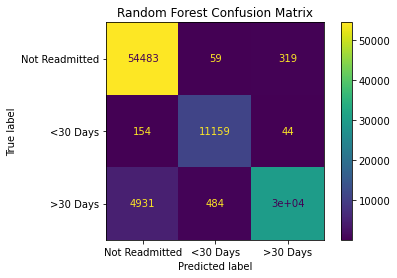

In [110]:
plot_confusion_matrix(grid_rf_clf, X, y, display_labels=outcomes)
plt.title("Random Forest Confusion Matrix")
plt.savefig("image\\rf_confusion_matrix.png")

#### Feature Importances

In [29]:
all_feature_grid_models = pd.read_csv(r"model\all_model_feature_weight.csv")

In [30]:
all_feature_grid_models.head(10)

,Unnamed: 0,grid_decisiontree,grid_dt_select_features,grid_rf_select_features
0,num_lab_procedures,0.108521,0.013603,0.112865
1,num_medications,0.087609,0.055800,0.091340
2,number_inpatient,0.062436,0.108521,0.045307
3,time_in_hospital,0.055800,0.037206,0.058856
4,number_diagnoses,0.039468,0.087609,0.038103
5,num_procedures,0.037206,0.019364,0.040027
6,discharge_disposition_id_11,0.019802,0.018603,0.012951
7,number_outpatient,0.019364,0.062436,0.016905
8,number_emergency,0.018603,0.039468,0.013630
9,gender,0.013603,0.010450,0.016418
